# Importing Libraries

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt

c:\Users\arora\miniconda3\envs\nlp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading Dataset (IMDb test dataset)

                                                text  label
0  I love sci-fi and am willing to put up with a ...      0
1  Worth the entertainment value of a rental, esp...      0
2  its a totally average film with a few semi-alr...      0
3  STAR RATING: ***** Saturday Night **** Friday ...      0
4  First off let me say, If you haven't enjoyed a...      0


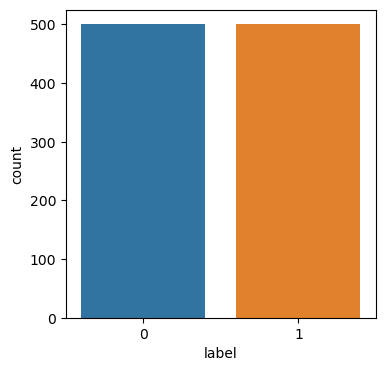

In [2]:
# Load IMDb dataset (test data , 1000 instances)

test_data = pd.read_csv('test_data.csv')
print(test_data.head())

#test dataset category count plot 
plt.figure(figsize=(4, 4))
sns.countplot(x='label', data=test_data)
plt.show()

# Pretrained Models Used

In [3]:
# Pretrained models for sentiment analysis
models = [
    "cardiffnlp/twitter-roberta-base-sentiment",
    "textattack/bert-base-uncased-SST-2",
    "aychang/roberta-base-imdb",
    "t5-small"
]


# Tokenizing and Getting predictions 

In [4]:


# Tokenize and get predictions for each model
results = []

for model_name in models:
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)

    predictions = []

    for i in range(len(test_data)):
        example = test_data.iloc[i,:]
        # print(example)
        inputs = tokenizer(example["text"], return_tensors="pt", max_length=500,truncation=True)
        # print(inputs)
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()
        predictions.append(predicted_class)
    # print(predictions)

    results.append(predictions)


c:\Users\arora\miniconda3\envs\nlp\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\arora\miniconda3\envs\nlp\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


# Evaluating Predictions

In [ ]:
# Evaluate model performance using metrics
metrics_data = []

for i, model_name in enumerate(models):
    true_labels = test_data.iloc[:,1]
    predicted_labels = results[i]

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average="weighted" , zero_division=0)
    recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    f1 = f1_score(true_labels, predicted_labels, average="weighted")

    metrics_data.append({"Model": f"Model_{i}", "Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1": f1})

# Create a DataFrame to store the metrics
metrics_df = pd.DataFrame(metrics_data)
print(metrics_df)



     Model  Accuracy  Precision  Recall        F1
0  Model_0     0.503   0.761503   0.503  0.585072
1  Model_1     0.901   0.901130   0.901  0.900992
2  Model_2     0.947   0.947403   0.947  0.946988
3  Model_3     0.500   0.250000   0.500  0.333333


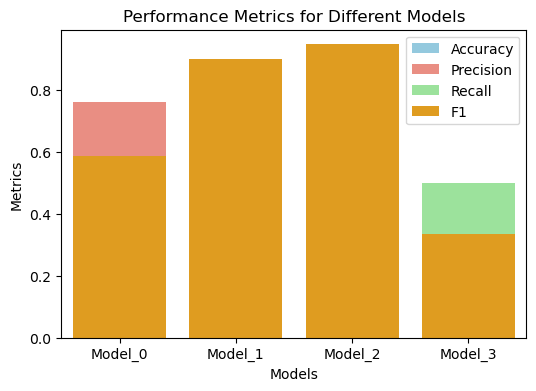

In [ ]:
plt.figure(figsize=(6, 4))

# Plotting metrics for different models
sns.barplot(x='Model', y='Accuracy', data=metrics_df, label='Accuracy', color='skyblue')
sns.barplot(x='Model', y='Precision', data=metrics_df, label='Precision', color='salmon')
sns.barplot(x='Model', y='Recall', data=metrics_df, label='Recall', color='lightgreen')
sns.barplot(x='Model', y='F1', data=metrics_df, label='F1', color='orange')

# Adding labels and title
plt.xlabel('Models')
plt.ylabel('Metrics')
plt.title('Performance Metrics for Different Models')
plt.legend()

# Show the plot
plt.show()

# Defining TOPSIS function

In [ ]:
#defining the TOPSIS function

def TOPSIS(array , weights ,signs):

    #preserving original array values
    original_array = array.copy()
    array = array.iloc[:,1:]
    
    #normalizing array
    normalized_array = array/np.linalg.norm(array, axis=0)
    #weighted array
    array_weighted = normalized_array*weights

    #best and worst values 
    best_values = np.max(array_weighted, axis=0) if any(signs) else np.min(array_weighted, axis=0)
    worst_values = np.min(array_weighted, axis=0) if any(signs) else np.max(array_weighted, axis=0)

    #calculating distances
    distance_best = np.linalg.norm(array_weighted - best_values, axis=1)
    distance_worst = np.linalg.norm(array_weighted - worst_values, axis=1)

    #calculating topsis scores
    topsis_scores = distance_worst / (distance_best + distance_worst)

    #appending scores in array
    modified_array = np.column_stack((original_array, topsis_scores))

    #appending rank
    ranked_indices = np.argsort(topsis_scores)[::-1]
    ranked_array = modified_array[ranked_indices]

    # Append ranks to the ranked matrix
    ranks = np.arange(1, len(array) + 1)
    ranked_array = np.column_stack((ranked_array, ranks))

    #returning ranked array
    return ranked_array

# Applying TOPSIS

In [ ]:
# Defining weights for criteria
weights = [0.25, 0.25, 0.25, 0.25]

# Maximizing or Minimizing the parameter
signs = [1,1,1,1]


ranked_array = pd.DataFrame(TOPSIS(metrics_df, weights, signs))
ranked_array.columns = ["Model","accuracy" , "precision" , "recall" , "F1 Score" , "Topsis Score" , "TOPSIS Rank"]


print(ranked_array)


     Model accuracy precision recall  F1 Score Topsis Score TOPSIS Rank
0  Model_2    0.947  0.947403  0.947  0.946988          1.0           1
1  Model_1    0.901   0.90113  0.901  0.900992     0.917854           2
2  Model_0    0.503  0.761503  0.503  0.585072     0.426789           3
3  Model_3      0.5      0.25    0.5  0.333333          0.0           4
